In [1]:
from kcoef_utils import *
import numpy as np
import scipy
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import cm
try:
    %matplotlib widget
except:
    %matplotlib inline

# Ground Truth


In [2]:
T = 1.0
L = 1.0
k = float(0.05)

nx = 20
nt = 10

h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0. + h, L-h, nx-1)
m_true = 0.5 - np.abs(x-0.5)
m = m_true

inv_solv = inv_solver(T, L, k, nx, nt, m)
inv_solv.FWDsolve()

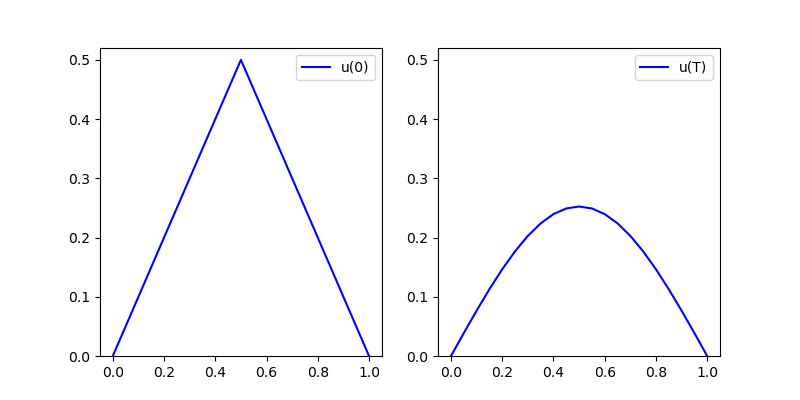

In [3]:
## Plotting the solutions
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# ploting the initial solution
plot(inv_solv.temps[...,0], L, nx, "-b", label = 'u(0)')
# plot(T[...,0], L, nx, "og", label = 'd')
plt.ylim([0,0.52])
plt.legend()
plt.subplot(1,2,2)
# plotting the solution after time steps
plot(inv_solv.temps[...,-1], L, nx, "-b", label = 'u(T)')
plt.ylim([0,0.52])
plt.legend()
plt.show()

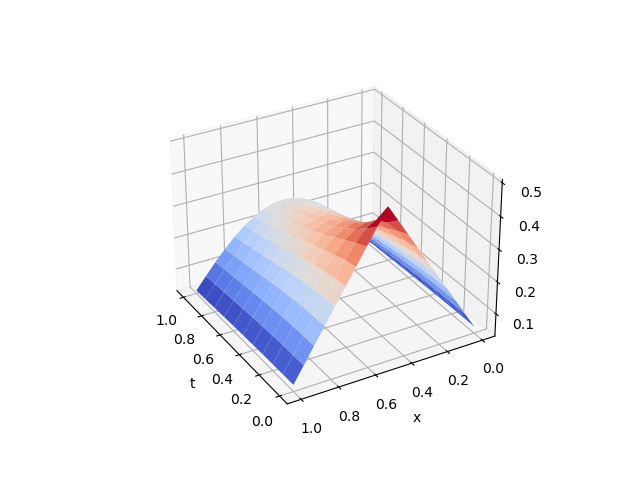

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.clear
ts = np.linspace(0, 1, nt+1)
xs = np.linspace(0, L, nx-1)

X, Y = np.meshgrid(ts, xs)
surf = ax.plot_surface(X,Y,inv_solv.temps,cmap=cm.coolwarm)

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.view_init(elev=30, azim=150)

## Numerical Solution

now we have the numerical solution


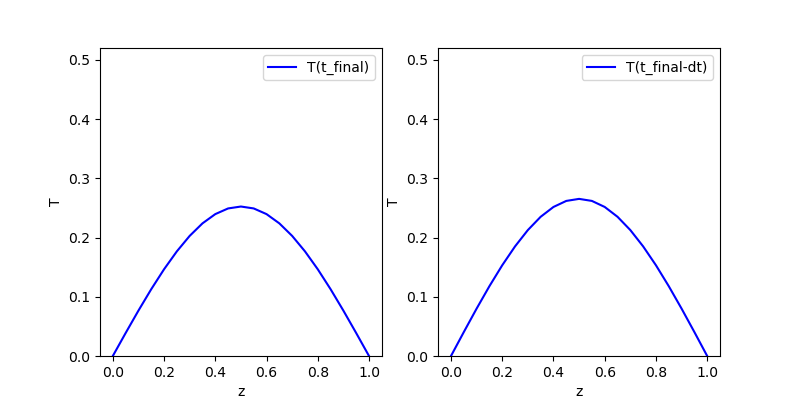

In [17]:
## Plotting the solutions
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# ploting the initial solution
plot(inv_solv.temps[...,-1], L, nx, "-b", label = 'T(t_final)')
# plot(T[...,0], L, nx, "og", label = 'd')
plt.xlabel('z')
plt.ylabel('T')
plt.ylim([0,0.52])
plt.legend()
plt.subplot(1,2,2)
# plotting the solution after time steps
plot(inv_solv.temps[...,-2], L, nx, "-b", label = 'T(t_final-dt)')
plt.xlabel('z')
plt.ylabel('T')
plt.ylim([0,0.52])
plt.legend()
plt.show()

## Data Generation
data will be $T^N$ and $T^{N-1}$

In [6]:
noise_std_dev = 1e-3

d = inv_solv.temps[...,0:2] # d = [T^N-1, T^N]
# d +=  noise_std_dev * np.random.randn(*d.shape)

In [7]:
coef = np.array((-1, 1)) / dt # coefficient for forward euler
dTdt = d @ coef # matrix multiply d and x to get a vector of dTdt
print(dTdt.shape)

(19,)


In [8]:
k_z = np.zeros(nx-1)

diagonals = np.zeros((3,nx-1))
diagonals[0,:] =  1.0/h**2
diagonals[1,:] = -2.0/h**2
diagonals[2,:] =  1.0/h**2

A = sp.spdiags(diagonals, [-1,0,1], nx-1, nx-1).toarray()

for i in range(nx-1):
    '''
    obtain int_-D^z dTdt where z will be i.
    
    output a scalar of k coefficient at different selected z
    '''
    int_dTdt = inv_solv.int_dTdt(dTdt, i+1)
    d2Tdz2 = A[i,...] @ d[..., -1] # A is coef of central diff; d[...,-1] is T^N 
    k_z[i] = int_dTdt / d2Tdz2

Here I'm going to define bottom of the lake to be the first term so ```dTdt[0]``` is -D and ```dTdt[-1]``` is the surface of the water

In [9]:
dTdt

array([-0.00097656, -0.0024414 , -0.00512695, -0.01037597, -0.02081297,
       -0.04165645, -0.08332817, -0.16666396, -0.33333174, -0.6666654 ,
       -0.33333174, -0.16666396, -0.08332817, -0.04165645, -0.02081297,
       -0.01037597, -0.00512695, -0.0024414 , -0.00097656])

In [10]:
k_z.shape

(19,)

In [11]:
np.average(k_z)

0.4789544853015335

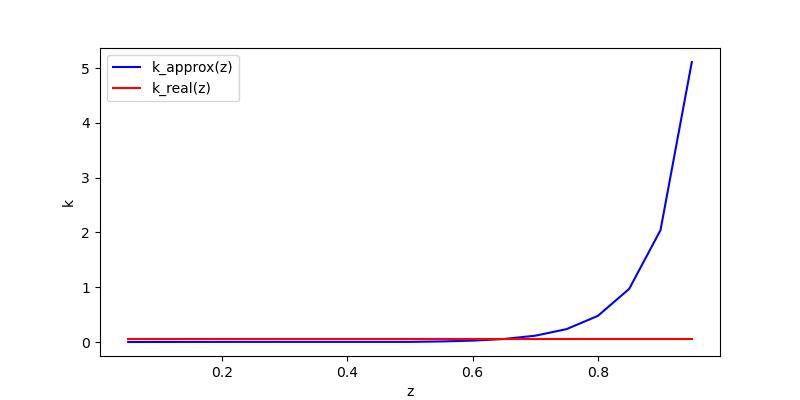

In [15]:
## Plotting the solutions
plt.figure(figsize=(8,4))
# plt.subplot(1,2,1)
# ploting the initial solution
plt.plot(x, k_z, "-b", label = 'k_approx(z)')
plt.plot(x, k * np.ones(nx-1), "-r", label = 'k_real(z)')
# plt.ylim([0.025,0.075])
# plt.xlim([0,0.5])
plt.legend()
plt.xlabel('z')
plt.ylabel('k')
plt.legend()
plt.show()

# Inverse Solve on Coarse Grid

In [35]:
int_dTdx, dTdx = inv_solv.solveINVFWD(inv_solv.temps[...,-1])

In [25]:
noise_std_dev = 1e-3

d = int_dTdx + noise_std_dev * np.random.randn(int_dTdx.shape[0])

k_approx = sp.linalg.spsolve(sp.csc_matrix(dTdx), d)

In [26]:

np.linalg.cond(sp.csr_matrix(dTdx).toarray())

12.328068009485794

std: 0.001
True k: 0.05
Pred k: 0.05021808854608686


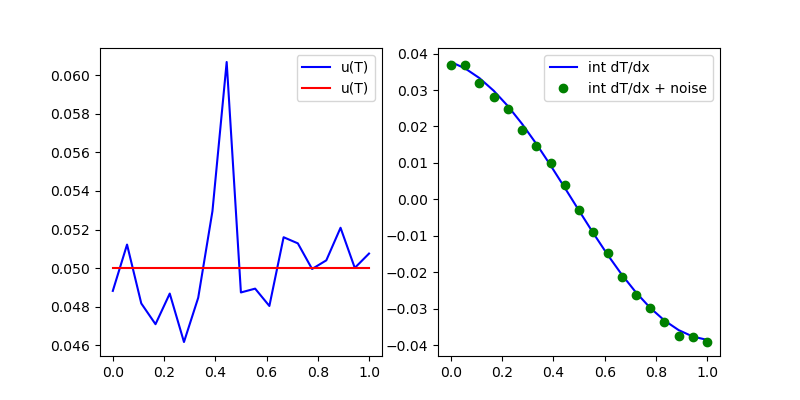

In [27]:
x = np.linspace(0., L, nx-1)

print('std:', noise_std_dev)
print('True k:', k)
print('Pred k:', np.average(k_approx))

## Plotting the solutions
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# ploting the initial solution
plt.plot(x, k_approx, "-b", label = 'u(T)')
plt.plot(x, k * np.ones(nx-1), "-r", label = 'u(T)')
# plt.ylim([0.025,0.075])
plt.legend()
plt.subplot(1,2,2)
# plotting the solution after time steps
plt.plot(x, int_dTdx, "-b", label = 'int dT/dx')
plt.plot(x, d, "og", label = 'int dT/dx + noise')

plt.legend()
plt.show()

# Inverse Solve on Fine Grid

In [9]:
T = 1.0
L = 1.0
k = float(0.05)

nx = 100
nt = 100

h = L/float(nx)
dt = T/float(nt)

x = np.linspace(0. + h, L-h, nx-1)
m_true = 0.5 - np.abs(x-0.5)
m = m_true

inv_solv = inv_solver(T, L, k, nx, nt, m)
inv_solv.FWDsolve()

int_dTdx, dTdx = inv_solv.solveINVFWD(inv_solv.temps[...,-1])

In [10]:
noise_std_dev = 1e-3

d = int_dTdx + noise_std_dev * np.random.randn(int_dTdx.shape[0])

k_approx = sp.linalg.spsolve(sp.csc_matrix(dTdx), d)

std: 0.001
True k: 0.05
Pred k: 0.048822397585135686


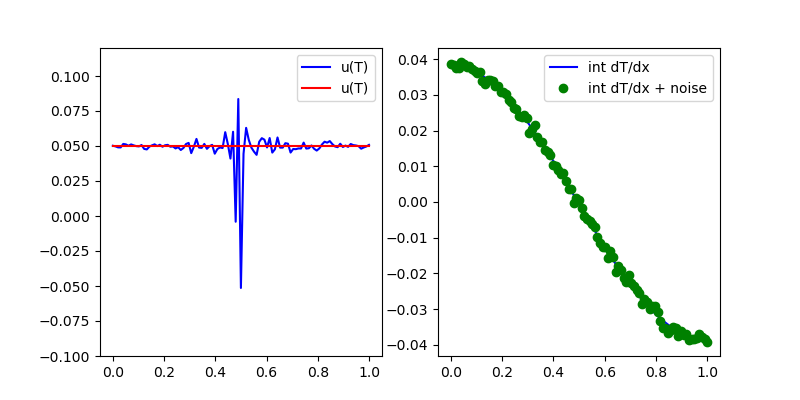

In [11]:
x = np.linspace(0., L, nx-1)

print('std:', noise_std_dev)
print('True k:', k)
print('Pred k:', np.average(k_approx))

## Plotting the solutions
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
# ploting the initial solution
plt.plot(x, k_approx, "-b", label = 'u(T)')
plt.plot(x, k * np.ones(nx-1), "-r", label = 'u(T)')
plt.ylim([-0.1,0.12])
plt.legend()
plt.subplot(1,2,2)
# plotting the solution after time steps
plt.plot(x, int_dTdx, "-b", label = 'int dT/dx')
plt.plot(x, d, "og", label = 'int dT/dx + noise')

plt.legend()
plt.show()

## Solving the Optimization Problem with Regularization
With the inverse problem and matrix $A$, we can find the analytic solution of $k$ with Tikhonov regularization applied by solving for the following optimization problem

$$
\min_k \frac{1}{2}\left[ ||Ak - d||^2 + \alpha ||k||^2\right].
$$

If we work it out analytically, we will obtain

$$
k_\alpha = \frac{F^Td}{F^TF + \alpha}
$$

where $k_\alpha$ is the approximation of the coefficient with regularization applied to the singular value applied to the operator $A$.

In [12]:
F = sp.csr_matrix(dTdx).toarray()

true:  0.05
pred:  0.048822397585135686
1.000000e-04: 0.04858425100039812
1.000000e-03: 0.04761301100208466
1.000000e-02: 0.04354496428192378
1.000000e-01: 0.03111524277715721
1.000000e+00: 0.010469150150488892


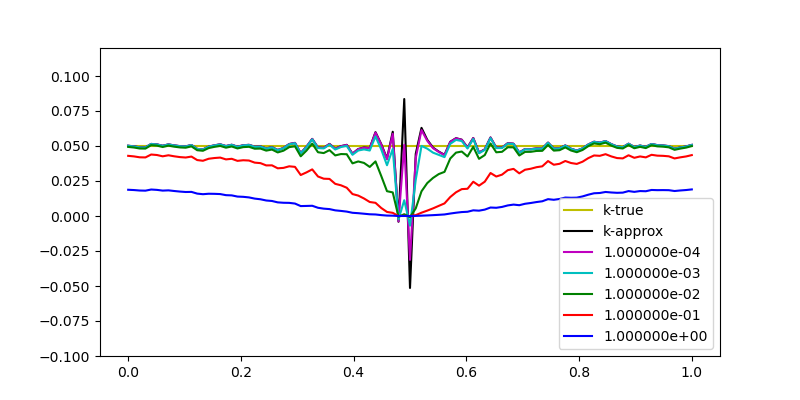

In [13]:
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1.]
colors = ['b', 'r', 'g', 'c', 'm']

print('true: ',k)
print('pred: ',np.average(k_approx))

x = np.linspace(0., L, nx-1)

## Plotting the solutions
plt.figure(figsize=(8,4))
# ploting the initial solution
plt.plot(x, k * np.ones(nx-1), "-y", label = 'k-true')
plt.plot(x, k_approx, "-k", label = 'k-approx')
for i in range(len(alpha)):
    k_alpha = inv_solv.solveTikhonov(d, F, alpha[i])
    plt.plot(x, k_alpha, '-'+colors.pop(), label = '{0:e}'.format(alpha[i]))
    print('{0:e}:'.format(alpha[i]), np.average(k_alpha))
    

# plt.ylim([0.025,0.075])
plt.ylim([-0.1,0.12])
plt.legend()

plt.legend()
plt.show()

In [ ]:
## Plotting the solutions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# ploting the initial solution
plot(T[..., -1], L, nx, "-b", label = 'u(T)')
plot(Tf, L, nx, "-r", label = 'u_hat(T) approx k')
plt.title('Comparison with different k')
plt.ylim([0,0.52])
plt.legend()

plt.subplot(1,2,2)
plot(np.abs(T[...,-1]-Tf), L, nx, "-b", label = 'abs(u(T) - u_hat(T))')
plt.title('error plot')
plt.ylim([0,0.52])
plt.legend()
plt.show()